## Import library

In [ ]:
pip install transformers

In [ ]:
pip install vncorenlp

In [ ]:
pip install transformers[torch]

In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

In [ ]:
pip install underthesea

In [ ]:
pip install scikit-learn

In [ ]:
pip install torch

In [ ]:
import os
import re
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from vncorenlp import VnCoreNLP
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

## 3. Load model BERT

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4. Connect to Google Drive


In [ ]:
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/vncorenlp/VnCoreNLP-1.1.1.jar
/kaggle/working/vncorenlp/models/wordsegmenter/vi-vocab
/kaggle/working/vncorenlp/models/wordsegmenter/wordsegmenter.rdr


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/test-set-spam/test8pt.csv
/kaggle/input/test-set-spam/test10pt.csv
/kaggle/input/test-set-spam/test0cham5pt.csv
/kaggle/input/test-set-spam/test2pt.csv
/kaggle/input/test-set-spam/test1pt.csv
/kaggle/input/test-set-spam/test5pt.csv
/kaggle/input/spam-review/spam/vietnamese-stopwords-dash.txt
/kaggle/input/spam-review/spam/dataset/dev.csv
/kaggle/input/spam-review/spam/dataset/train.csv
/kaggle/input/spam-review/spam/dataset/test.csv


In [ ]:
DIR_ROOT = '/kaggle/input/spam-review/spam'
DIR_DATASET = os.path.join(DIR_ROOT, 'dataset')

PATH_TRAIN = os.path.join(DIR_DATASET, 'train.csv')
PATH_DEV = os.path.join(DIR_DATASET, 'dev.csv')

STOPWORDS_PATH = os.path.join(DIR_ROOT, 'vietnamese-stopwords-dash.txt')

MODEL_DIR = os.path.join('/kaggle/working', 'transformer_model')
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [ ]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

## 5. Load data

In [ ]:
# Assuming PATH_TRAIN is the path to your training data CSV file
train_data = pd.read_csv(PATH_TRAIN)

# Filter rows where 'Label' is 0
train_data = train_data[train_data['Label'] == 0]

# Drop 'SpamLabel' column
train_data = train_data.drop('SpamLabel', axis=1)

# Select features (X) and labels (y)
X = train_data.iloc[:, 0:2]
y = train_data.iloc[:, 2:4]

# Split the data into training and development sets
X_train, X_dev, y_train, y_dev = train_test_split(X, y, train_size=6000, test_size=1500, random_state=42)

In [ ]:
vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [ ]:
with open(STOPWORDS_PATH, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

In [ ]:
def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)

    return train_sentences


def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


def preprocess(text, tokenized=True, lowercased=True):
    # text = ViTokenizer.tokenize(text)
    # text = ' '.join(vncorenlp.tokenize(text)[0])
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    if tokenized:
        pre_text = ""
        sentences = vncorenlp.tokenize(text)
        for sentence in sentences:
            pre_text += " ".join(sentence)
        text = pre_text
    return text


def pre_process_features(X, y1, tokenized=True, lowercased=True):
    X = np.array(X)
    y1 = np.array(y1)
    X = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y1, idx)
    return X, y1

In [ ]:
train_X, train_y = pre_process_features(X_train['Comment'], y_train['Label'], tokenized=True, lowercased = False)
dev_X, dev_y = pre_process_features(X_dev['Comment'], y_dev['Label'], tokenized=True, lowercased = False)

## Extract embedding

In [ ]:
train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)

In [ ]:
# Create datasets using the custom BuildDataset class
train_dataset = BuildDataset(train_encodings, torch.tensor(train_y))
dev_dataset = BuildDataset(dev_encodings, torch.tensor(dev_y))

In [ ]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=8, shuffle=False)

In [ ]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Function to extract embeddings
def extract_embeddings(model, data_loader):
    model.eval()
    model.to(device)
    embeddings = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Obtain embeddings from the PhoBERT model
            features = phobert(input_ids, attention_mask=attention_mask)

            # Assuming you want to extract embeddings from the last layer
            last_hidden_states = features.last_hidden_state

            # Append the embeddings to the list
            embeddings.append(last_hidden_states.cpu().numpy())

    # Concatenate the embeddings from different batches
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

In [ ]:
# Extract embeddings for train, dev, and test datasets
train_embeddings = extract_embeddings(phobert, train_loader)

/tmp/ipykernel_961/3335929433.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/tmp/ipykernel_961/3335929433.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


In [ ]:
dev_embeddings = extract_embeddings(phobert, dev_loader)

/tmp/ipykernel_961/3335929433.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


In [ ]:
train_embeddings.shape

(6000, 100, 768)

## AutoEncoder

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, RepeatVector, Dense, Input, Bidirectional, Dropout, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Input shape
input_size = 768
timestep = 100

# Encoder
encoder_inputs = Input(shape=(timestep, input_size))

encoder_l1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(encoder_inputs)
encoder_l2 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2))(encoder_l1)
encoder_l3 = Bidirectional(LSTM(32, return_sequences=True, dropout=0.2))(encoder_l2)
encoder_l4 = Bidirectional(LSTM(16, return_sequences=True, dropout=0.2))(encoder_l3)
encoder_l5 = Bidirectional(LSTM(8, dropout=0.2))(encoder_l4)

# Attention
attention = Attention()([encoder_l5, encoder_l5])

# Decoder
decoder_l1 = RepeatVector(timestep)(attention)
decoder_l2 = Bidirectional(LSTM(16, return_sequences=True, dropout=0.2))(decoder_l1)
decoder_l3 = Bidirectional(LSTM(32, return_sequences=True, dropout=0.2))(decoder_l2)
decoder_l4 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2))(decoder_l3)
decoder_outputs = Bidirectional(LSTM(384, return_sequences=True, dropout=0.2))(decoder_l4)

# Model
model = Model(inputs=encoder_inputs, outputs=decoder_outputs)

In [ ]:
# Learning Rate Schedule
initial_lr = 0.001

def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        lr = lr * 0.9
    return lr

optimizer = Adam(learning_rate=initial_lr)
lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
# Summarize the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 100, 768)]           0         []                            
                                                                                                  
 bidirectional_27 (Bidirect  (None, 100, 256)             918528    ['input_6[0][0]']             
 ional)                                                                                           
                                                                                                  
 bidirectional_28 (Bidirect  (None, 100, 128)             164352    ['bidirectional_27[0][0]']    
 ional)                                                                                           
                                                                                            

In [ ]:
# Define the number of epochs and batch size
num_epochs = 50
batch_size = 32

# Train the model
history = model.fit(
    train_embeddings,  # input data
    train_embeddings,  # target data (autoencoder reconstructs the input)
    epochs=num_epochs,
    batch_size=batch_size,
    shuffle=True,  # Shuffle the data during training
    callbacks=[lr_scheduler]  # Use the learning rate scheduler callback
)

Epoch 1/50
188/188 [==============================] - 43s 74ms/step - loss: 0.0420 - lr: 0.0010
Epoch 2/50
188/188 [==============================] - 14s 73ms/step - loss: 0.0366 - lr: 0.0010
Epoch 3/50
188/188 [==============================] - 14s 74ms/step - loss: 0.0362 - lr: 0.0010
Epoch 4/50
188/188 [==============================] - 14s 73ms/step - loss: 0.0359 - lr: 0.0010
Epoch 5/50
188/188 [==============================] - 14s 74ms/step - loss: 0.0358 - lr: 0.0010
Epoch 6/50
188/188 [==============================] - 14s 73ms/step - loss: 0.0356 - lr: 0.0010
Epoch 7/50
188/188 [==============================] - 14s 74ms/step - loss: 0.0356 - lr: 0.0010
Epoch 8/50
188/188 [==============================] - 14s 73ms/step - loss: 0.0354 - lr: 0.0010
Epoch 9/50
188/188 [==============================] - 14s 75ms/step - loss: 0.0354 - lr: 0.0010
Epoch 10/50
188/188 [==============================] - 14s 73ms/step - loss: 0.0353 - lr: 0.0010
Epoch 11/50
188/188 [==================

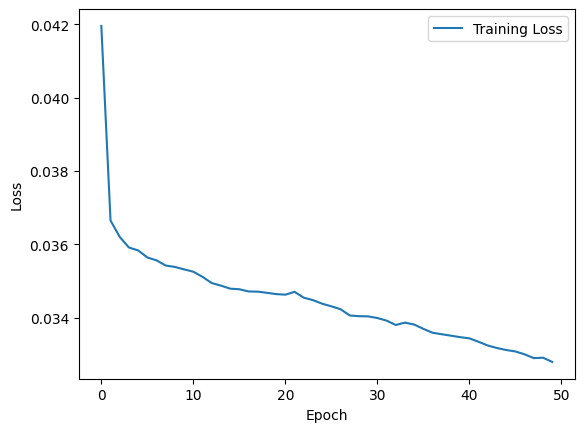

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
PATH_TEST = os.path.join('/kaggle/input/spam-review/spam/dataset', 'test.csv')
test_data = pd.read_csv(PATH_TEST)
X_test = test_data.iloc[:, 1:2]
y_test = test_data.iloc[:, 2:3]

In [ ]:
test_X, test_y = pre_process_features(X_test['Comment'], y_test['Label'], tokenized=True, lowercased = False)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)
test_dataset = BuildDataset(test_encodings, torch.tensor(test_y))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)
test_embeddings = extract_embeddings(phobert, test_loader)

/tmp/ipykernel_961/3335929433.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


In [ ]:
test_preds = model.predict(test_embeddings)

125/125 [==============================] - 10s 32ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, accuracy_score

# Calculate reconstruction error using Mean Squared Error (MSE)
mse_errors = [mean_squared_error(test_embeddings[i], test_preds[i]) for i in range(len(test_embeddings))]

In [ ]:
# Loop to find the threshold for the best accuracy
best_threshold = 0
best_accuracy = 0

for threshold in range(1, 100):  # Adjust the range based on your specific needs
    threshold /= 100  # Normalize to a value between 0 and 1

    # Apply threshold to classify as anomaly or normal
    predictions = [1 if mse > threshold else 0 for mse in mse_errors]

    # Calculate accuracy
    accuracy = accuracy_score(test_y, predictions)

    # Update best threshold if accuracy improves
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print("Best Threshold:", best_threshold)
print("Best Accuracy:", best_accuracy)

Best Threshold: 0.06
Best Accuracy: 0.7611977856064419


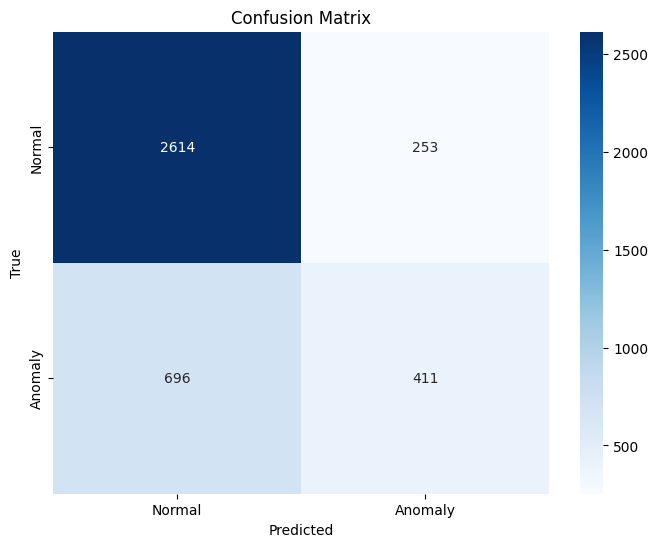

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Apply the best threshold to classify instances
predictions = [1 if mse > best_threshold else 0 for mse in mse_errors]

# Create Confusion Matrix
cm = confusion_matrix(test_y, predictions)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

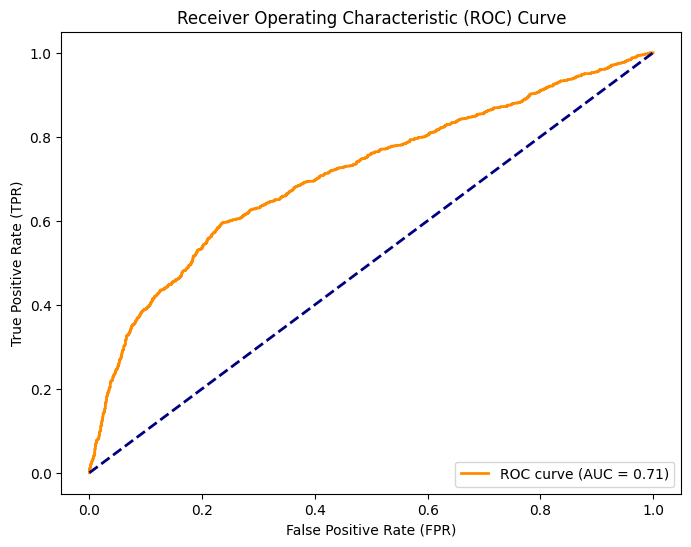

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(test_y, mse_errors)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score

# Calculate F1
f1 = f1_score(test_y, predictions, average='micro')
print("F1 Micro:", f1)

F1 Micro: 0.7611977856064419


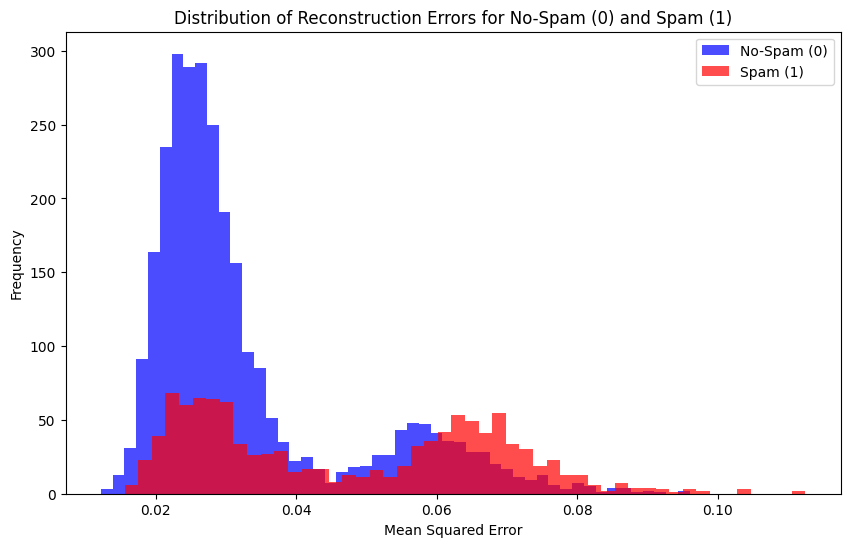

In [ ]:
# Separate MSE errors for no-spam (0) and spam (1)
no_spam_errors = [mse for mse, label in zip(mse_errors, test_y) if label == 0]
spam_errors = [mse for mse, label in zip(mse_errors, test_y) if label == 1]

# Plot histograms for both no-spam and spam in the same figure
plt.figure(figsize=(10, 6))

# Plot histogram for no-spam errors
plt.hist(no_spam_errors, bins=50, color='blue', alpha=0.7, label='No-Spam (0)')

# Plot histogram for spam errors
plt.hist(spam_errors, bins=50, color='red', alpha=0.7, label='Spam (1)')

plt.title('Distribution of Reconstruction Errors for No-Spam (0) and Spam (1)')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()

plt.show()

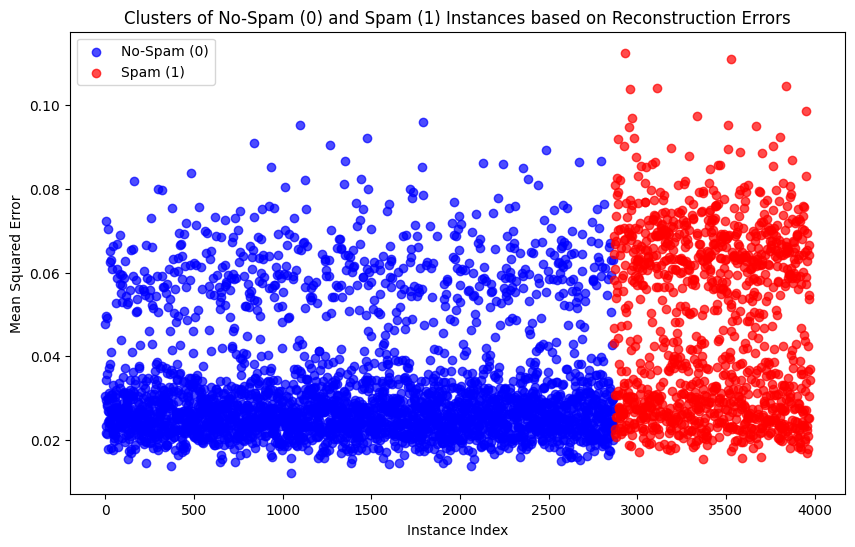

In [ ]:
import matplotlib.pyplot as plt

# Separate MSE errors for no-spam (0) and spam (1)
no_spam_errors = [mse for mse, label in zip(mse_errors, test_y) if label == 0]
spam_errors = [mse for mse, label in zip(mse_errors, test_y) if label == 1]

# Plot clusters using a scatter plot
plt.figure(figsize=(10, 6))

# Plot cluster for no-spam errors
plt.scatter(range(len(no_spam_errors)), no_spam_errors, color='blue', alpha=0.7, label='No-Spam (0)')

# Plot cluster for spam errors
plt.scatter(range(len(no_spam_errors), len(mse_errors)), spam_errors, color='red', alpha=0.7, label='Spam (1)')

plt.title('Clusters of No-Spam (0) and Spam (1) Instances based on Reconstruction Errors')
plt.xlabel('Instance Index')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.show()